# Tutorial: Multimodal RNA + ATAC Analysis with SnapATAC2

Audience:
- Computational biologists and bioinformatics users working with single-cell multiome data.

Prerequisites:
- Python environment with `scanpy`, `snapatac2`, `anndata`, and plotting dependencies installed.
- Basic familiarity with AnnData objects and single-cell preprocessing.

Learning goals:
- Load paired RNA and ATAC modalities from a common multiome dataset.
- Build modality-specific embeddings and clusters.
- Build a joint multimodal embedding using `snap.tl.multi_spectral`.


## Outline

1. Setup
2. Discover local samples and checkpoint per-sample files
3. Build combined RNA and ATAC objects from per-sample h5ad
4. RNA preprocessing and embedding
5. ATAC preprocessing and embedding
6. Joint multimodal embedding and clustering
7. Pitfalls, exercises, and extensions


In [14]:
from __future__ import annotations

import importlib
from pathlib import Path

import anndata as ad
import pandas as pd
import scanpy as sc
import snapatac2 as snap
import utils.dbit_rna_reader as dbit_rna_reader

# Force reload so notebook picks up reader edits after restarts.
dbit_rna_reader = importlib.reload(dbit_rna_reader)
discover_rna_tissue_pairs = dbit_rna_reader.discover_rna_tissue_pairs
discover_atac_fragment_tars = dbit_rna_reader.discover_atac_fragment_tars
extract_atac_fragment_archives = dbit_rna_reader.extract_atac_fragment_archives
import_atac_fragments_to_h5ad_per_sample = dbit_rna_reader.import_atac_fragments_to_h5ad_per_sample
read_dbit_rna_directory = dbit_rna_reader.read_dbit_rna_directory
write_rna_h5ad_per_sample = dbit_rna_reader.write_rna_h5ad_per_sample

sc.settings.verbosity = 2
sc.settings.set_figure_params(figsize=(5, 5), frameon=False)

print("scanpy:", sc.__version__)
print("snapatac2:", snap.__version__)


scanpy: 1.11.5
snapatac2: 2.8.0


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_86456/3232054202.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("scanpy:", sc.__version__)


## Step 1 - Discover local DBiT RNA + ATAC samples

Discover all RNA/tissue pairs and matching ATAC tar files under `data-RNA` recursively (`atac/` and `cut_and_tag/`).


In [2]:
data_root = Path("data-RNA/atac")
pairs = discover_rna_tissue_pairs(data_root, recursive=True)
required = {"RNA_matrix", "tissue_positions_list"}
sample_ids = sorted([s for s, files in pairs.items() if required.issubset(files)])

if not sample_ids:
    raise RuntimeError(f"No complete RNA+tissue sample pairs found under {data_root}")

atac_tar_manifest = discover_atac_fragment_tars(
    data_dir=data_root,
    sample_ids=sample_ids,
    recursive=True,
)

sample_manifest = pd.DataFrame({"sample_id": sample_ids})
sample_manifest["has_atac_tar"] = sample_manifest["sample_id"].isin(set(atac_tar_manifest["sample_id"]))
print(f"Discovered RNA samples: {len(sample_ids)}")
print(f"Samples with ATAC tar: {sample_manifest['has_atac_tar'].sum()}")
sample_manifest


Discovered RNA samples: 7
Samples with ATAC tar: 7


,sample_id,has_atac_tar
0,06_LPC5S1,True
1,06_LPC5S2,True
2,07_LPC10S1,True
3,07_LPC10S2,True
4,08_LPC21S1,True
5,08_LPC21S2,True
6,LPC5_Saggital,True


### Step 1b - Checkpoint per-sample RNA h5ad and extracted ATAC fragments

Write one RNA h5ad per sample and extract fragment files from ATAC tar archives. These steps are resumable with `overwrite=False`.


In [ ]:
checkpoint_dir = Path("data/checkpoints")
rna_h5ad_dir = checkpoint_dir / "rna_h5ad_by_sample"
atac_frag_dir = checkpoint_dir / "atac_fragments_local"
atac_h5ad_dir = checkpoint_dir / "atac_h5ad_by_sample"

rna_h5ad_manifest = write_rna_h5ad_per_sample(
    data_dir=data_root,
    out_dir=rna_h5ad_dir,
    sample_ids=sample_ids,
    overwrite=False,
    recursive=True,
)

dbit_atac_manifest = extract_atac_fragment_archives(
    out_dir=atac_frag_dir,
    atac_manifest=atac_tar_manifest,
    overwrite=False,
)

print(f"RNA h5ad files: {(rna_h5ad_manifest['status'] != 'error').sum()}")
print(f"Extracted ATAC fragment sets: {len(dbit_atac_manifest)}")
rna_h5ad_manifest.head()


RNA h5ad files: 7
Extracted ATAC fragment sets: 7


,sample_id,status,rna_h5ad,rna_tar,tissue_positions_tar,n_obs,n_vars
0,06_LPC5S1,skipped_existing,data/checkpoints/rna_h5ad_by_sample/06_LPC5S1....,data-RNA/atac/06_LPC5S1_RNA_matrix.csv.tar,data-RNA/atac/06_LPC5S1_tissue_positions_list....,-1,-1
1,06_LPC5S2,written,data/checkpoints/rna_h5ad_by_sample/06_LPC5S2....,data-RNA/atac/06_LPC5S2_RNA_matrix.csv.tar,data-RNA/atac/06_LPC5S2_tissue_positions_list....,8169,32285
2,07_LPC10S1,written,data/checkpoints/rna_h5ad_by_sample/07_LPC10S1...,data-RNA/atac/07_LPC10S1_RNA_matrix.csv.tar,data-RNA/atac/07_LPC10S1_tissue_positions_list...,8180,32285
3,07_LPC10S2,written,data/checkpoints/rna_h5ad_by_sample/07_LPC10S2...,data-RNA/atac/07_LPC10S2_RNA_matrix.csv.tar,data-RNA/atac/07_LPC10S2_tissue_positions_list...,8928,32285
4,08_LPC21S1,written,data/checkpoints/rna_h5ad_by_sample/08_LPC21S1...,data-RNA/atac/08_LPC21S1_RNA_matrix.csv.tar,data-RNA/atac/08_LPC21S1_tissue_positions_list...,8485,32285


In [ ]:
RUN_LOCAL_ATAC_IMPORT = True
USE_RNA_BARCODE_WHITELIST = True
CONTINUE_ON_ERROR = True

if RUN_LOCAL_ATAC_IMPORT:
    # Choose the correct genome for your experiment, e.g., snap.genome.mm10 or snap.genome.hg38.
    genome = snap.genome.mm10

    whitelist_by_sample = None
    if USE_RNA_BARCODE_WHITELIST:
        whitelist_by_sample = {}
        for row in rna_h5ad_manifest.itertuples(index=False):
            sample_id = str(row.sample_id)
            a = sc.read_h5ad(str(row.rna_h5ad))
            if "barcode" in a.obs.columns:
                barcodes = a.obs["barcode"].astype(str).tolist()
            else:
                barcodes = a.obs_names.astype(str).tolist()
            whitelist_by_sample[sample_id] = barcodes
            del a

    atac_h5ad_manifest = import_atac_fragments_to_h5ad_per_sample(
        out_dir=atac_h5ad_dir,
        genome=genome,
        atac_manifest=dbit_atac_manifest,
        whitelist_by_sample=whitelist_by_sample,
        sorted_by_barcode=False,
        overwrite=True,
        continue_on_error=CONTINUE_ON_ERROR,
    )
    atac_h5ad_manifest
else:
    print("Set RUN_LOCAL_ATAC_IMPORT=True to import ATAC and write per-sample h5ad files.")


## Step 2 - Build paired local RNA and ATAC objects from per-sample h5ad

Load a subset of sample-level checkpoints first (recommended), then scale up to all samples after confirming memory usage.


In [5]:
# Recover manifests after kernel restart if needed.
if "rna_h5ad_manifest" not in globals():
    rna_h5ad_manifest = pd.DataFrame(
        {
            "sample_id": p.name.replace(".rna.h5ad", ""),
            "rna_h5ad": str(p),
            "status": "existing",
        }
        for p in sorted((Path("data/checkpoints") / "rna_h5ad_by_sample").glob("*.rna.h5ad"))
    )

if "atac_h5ad_manifest" not in globals():
    atac_h5ad_manifest = pd.DataFrame(
        {
            "sample_id": p.name.replace(".atac.h5ad", ""),
            "atac_h5ad": str(p),
            "status": "existing",
        }
        for p in sorted((Path("data/checkpoints") / "atac_h5ad_by_sample").glob("*.atac.h5ad"))
    )

rna_ok = set(rna_h5ad_manifest["sample_id"].astype(str))
atac_ok = set(atac_h5ad_manifest.loc[atac_h5ad_manifest["status"] != "error", "sample_id"].astype(str))
shared_samples = sorted(rna_ok.intersection(atac_ok))
if not shared_samples:
    raise RuntimeError("No shared RNA/ATAC sample-level h5ad files found.")

# Start small to avoid OOM; set to `shared_samples` for all samples.
samples_to_build = shared_samples[:2]
print("Shared samples:", shared_samples)
print("Building combined objects from samples:", samples_to_build)

rna_parts = []
for sample_id in samples_to_build:
    row = rna_h5ad_manifest.loc[rna_h5ad_manifest["sample_id"].astype(str) == sample_id].iloc[0]
    a = sc.read_h5ad(str(row.rna_h5ad))
    a.obs["sample_id"] = str(sample_id)
    if "barcode" not in a.obs.columns:
        a.obs["barcode"] = a.obs_names.astype(str)
    a.obs["barcode"] = a.obs["barcode"].astype(str)
    a.obs_names = (a.obs["sample_id"] + ":" + a.obs["barcode"]).to_numpy()
    a.obs_names_make_unique()
    rna_parts.append(a)

atac_parts = []
for sample_id in samples_to_build:
    row = atac_h5ad_manifest.loc[atac_h5ad_manifest["sample_id"].astype(str) == sample_id].iloc[0]
    try:
        a = snap.read(str(row.atac_h5ad), backed=None)
    except Exception:
        a = sc.read_h5ad(str(row.atac_h5ad))
    a.obs["sample_id"] = str(sample_id)
    a.obs["barcode"] = a.obs_names.astype(str).str.replace(r"-[0-9]+$", "", regex=True)
    a.obs_names = (a.obs["sample_id"] + ":" + a.obs["barcode"]).to_numpy()
    a.obs_names_make_unique()
    atac_parts.append(a)

rna = ad.concat(rna_parts, join="outer", merge="first")
atac = ad.concat(atac_parts, join="outer", merge="first")

print(rna)
print(atac)
print("Shared barcodes:", len(rna.obs_names.intersection(atac.obs_names)))


Shared samples: ['06_LPC5S1', '06_LPC5S2', '07_LPC10S1', '07_LPC10S2', '08_LPC21S1', '08_LPC21S2', 'LPC5_Saggital']
Building combined objects from samples: ['06_LPC5S1', '06_LPC5S2']


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 16905 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 16905 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample_id', 'barcode'
    obsm: 'fragment_paired'
Shared barcodes: 16905


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Step 3 - RNA preprocessing and embedding

Use a standard Scanpy workflow to build an RNA latent space and clusters.


In [6]:
# Checkpoint workflow: keep this placeholder cell to separate data loading from preprocessing.


In [7]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)

rna.raw = rna
rna = rna[:, rna.var["highly_variable"]].copy()

sc.pp.scale(rna)
sc.pp.pca(rna, n_comps=50)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.tl.leiden(rna)


normalizing counts per cell


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:12)
computing UMAP
    finished (0:00:05)
running Leiden clustering


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_86456/144694855.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna)


    finished (0:00:05)


... storing 'barcode' as categorical
... storing 'sample_id' as categorical


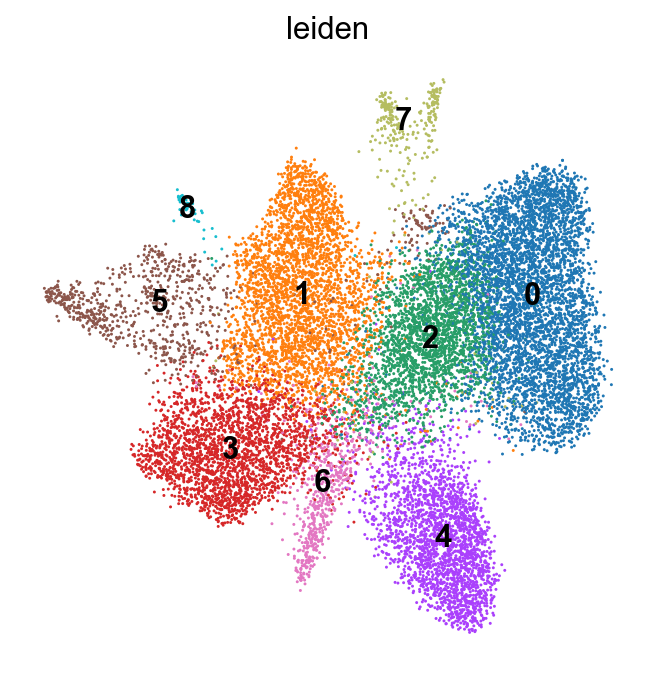

In [8]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")


## Step 4 - ATAC preprocessing and embedding

Run SnapATAC2 feature selection, spectral embedding, neighborhood graph, and clustering.


In [12]:
atac.obs

,n_fragment,frac_dup,frac_mito,sample_id,barcode
06_LPC5S1:AAACATCGAAACATCG,7833,0.389240,0.0,06_LPC5S1,AAACATCGAAACATCG
06_LPC5S1:AAACATCGAACAACCA,15408,0.426786,0.0,06_LPC5S1,AAACATCGAACAACCA
06_LPC5S1:AAACATCGAACCGAGA,17108,0.431382,0.0,06_LPC5S1,AAACATCGAACCGAGA
06_LPC5S1:AAACATCGAACGCTTA,16503,0.439779,0.0,06_LPC5S1,AAACATCGAACGCTTA
06_LPC5S1:AAACATCGAACGTGAT,9451,0.431485,0.0,06_LPC5S1,AAACATCGAACGTGAT
...,...,...,...,...,...
06_LPC5S2:TTCACGCATGAAGAGA,13839,0.408666,0.0,06_LPC5S2,TTCACGCATGAAGAGA
06_LPC5S2:TTCACGCATGGAACAA,24722,0.426523,0.0,06_LPC5S2,TTCACGCATGGAACAA
06_LPC5S2:TTCACGCATGGCTTCA,29515,0.429871,0.0,06_LPC5S2,TTCACGCATGGCTTCA
06_LPC5S2:TTCACGCATGGTGGTA,17029,0.417812,0.0,06_LPC5S2,TTCACGCATGGTGGTA


In [40]:
snap.pp.select_features(atac)
snap.tl.spectral(atac)
snap.pp.knn(atac)
snap.tl.umap(atac)
snap.tl.leiden(atac)


2026-02-11 15:28:13 - INFO - Selected 500000 features.
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



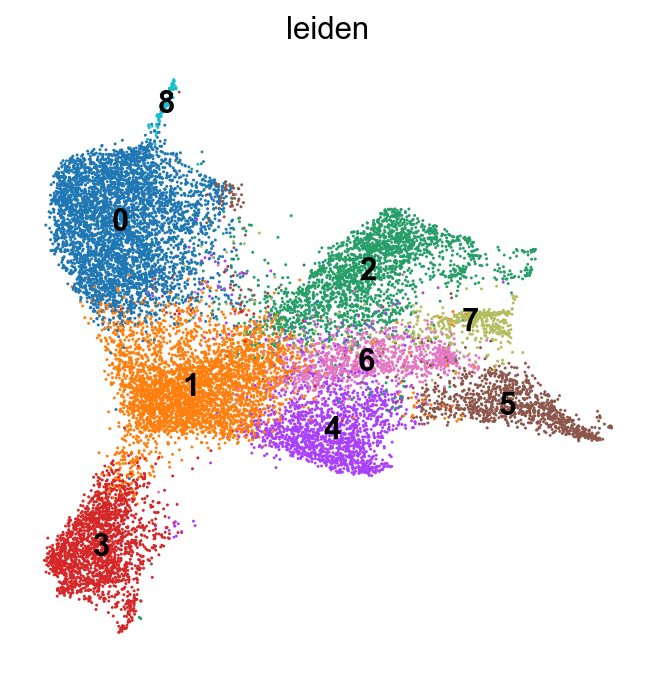

In [43]:
sc.pl.umap(atac, color="leiden", show=True, legend_loc = 'on data')


## Step 5 - Joint multimodal embedding

Align cells between modalities, build a multimodal container, and compute a joint representation.


In [ ]:
from scipy import sparse
import numpy as np

shared_cells = rna.obs_names.intersection(atac.obs_names)
if len(shared_cells) == 0:
    raise RuntimeError("No shared cells between RNA and ATAC.")

rna_shared = rna[shared_cells].copy()
atac_shared = atac[shared_cells].copy()

# Remove cells with no signal in either modality to stabilize eigendecomposition.
rna_nnz = np.ravel(np.asarray((rna_shared.X > 0).sum(axis=1))) if sparse.issparse(rna_shared.X) else np.ravel((rna_shared.X > 0).sum(axis=1))
atac_nnz = np.ravel(np.asarray((atac_shared.X > 0).sum(axis=1))) if sparse.issparse(atac_shared.X) else np.ravel((atac_shared.X > 0).sum(axis=1))
valid = (rna_nnz > 0) & (atac_nnz > 0)
if valid.sum() < 10:
    raise RuntimeError(f"Too few valid shared cells after filtering: {int(valid.sum())}")

rna_shared = rna_shared[valid].copy()
atac_shared = atac_shared[valid].copy()

# Convert to Snap AnnData objects via disk to match this SnapATAC2 API.
tmp_dir = Path("data/checkpoints/multimodal_inputs")
tmp_dir.mkdir(parents=True, exist_ok=True)
rna_path = tmp_dir / "rna_shared.h5ad"
atac_path = tmp_dir / "atac_shared.h5ad"

rna_shared.write_h5ad(rna_path)
if hasattr(atac_shared, "write_h5ad"):
    atac_shared.write_h5ad(atac_path)
else:
    atac_shared.write(atac_path)

rna_snap = snap.read(str(rna_path), backed=None)
atac_snap = snap.read(str(atac_path), backed=None)

if getattr(rna_snap, "X", None) is None or getattr(atac_snap, "X", None) is None:
    raise RuntimeError("RNA or ATAC matrix is missing before multi_spectral.")

# Rust backend expects sparse CSR-like matrices for this call.
if not sparse.issparse(rna_snap.X):
    rna_snap.X = sparse.csr_matrix(np.asarray(rna_snap.X))
elif not sparse.isspmatrix_csr(rna_snap.X):
    rna_snap.X = rna_snap.X.tocsr()

if not sparse.issparse(atac_snap.X):
    atac_snap.X = sparse.csr_matrix(np.asarray(atac_snap.X))
elif not sparse.isspmatrix_csr(atac_snap.X):
    atac_snap.X = atac_snap.X.tocsr()

rna_selected = np.asarray(rna_snap.var["selected"]).astype(bool) if "selected" in rna_snap.var.columns else np.ones(rna_snap.n_vars, dtype=bool)
atac_selected = np.asarray(atac_snap.var["selected"]).astype(bool) if "selected" in atac_snap.var.columns else np.ones(atac_snap.n_vars, dtype=bool)
if rna_selected.sum() < 5 or atac_selected.sum() < 5:
    raise RuntimeError("Too few selected features in RNA or ATAC for multimodal embedding.")

print(rna_snap)
print(atac_snap)
print("RNA selected features:", int(rna_selected.sum()), "/", rna_selected.size)
print("ATAC selected features:", int(atac_selected.sum()), "/", atac_selected.size)


... storing 'barcode' as categorical
... storing 'sample_id' as categorical


AnnData object with n_obs × n_vars = 16905 × 2632
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 16905 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample_id', 'barcode', 'leiden'
    var: 'count', 'selected'
    uns: 'leiden_colors', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'
RNA selected features: 2632 / 2632
ATAC selected features: 500000 / 5267565


In [39]:
atac_snap

AnnData object with n_obs × n_vars = 16905 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample_id', 'barcode', 'leiden'
    var: 'count', 'selected'
    uns: 'leiden_colors', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [33]:
from scipy.sparse.linalg import ArpackError
import numpy as np

def _zscore(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32)
    mu = x.mean(axis=0, keepdims=True)
    sd = x.std(axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    return (x - mu) / sd

max_rank = max(2, rna_snap.n_obs - 2)
trial_dims = []
for k in [30, 20, 15, 10, 8, 6, 4]:
    kk = min(k, max_rank)
    if kk >= 2 and kk not in trial_dims:
        trial_dims.append(kk)

ms_ok = False
last_err = None
for n_comps in trial_dims:
    try:
        print(f"Trying multi_spectral with n_comps={n_comps}")
        _, evecs = snap.tl.multi_spectral(
            [rna_snap, atac_snap],
            features=[rna_selected, atac_selected],
            n_comps=n_comps,
            weighted_by_sd=False,
        )
        mdata = rna_snap
        mdata.obsm["X_spectral"] = evecs
        snap.pp.knn(mdata, use_rep="X_spectral")
        snap.tl.umap(mdata, use_rep="X_spectral")
        snap.tl.leiden(mdata)
        ms_ok = True
        print(f"multi_spectral succeeded with n_comps={n_comps}")
        break
    except ArpackError as e:
        last_err = e
        print(f"ARPACK failed for n_comps={n_comps}: {e}")

if not ms_ok:
    print(f"multi_spectral failed for all trials ({last_err}). Falling back to concatenated latent space.")

    if "X_pca" not in rna_shared.obsm:
        raise RuntimeError("RNA PCA embedding (X_pca) is missing. Run RNA preprocessing first.")
    if "X_spectral" not in atac_shared.obsm:
        raise RuntimeError("ATAC spectral embedding (X_spectral) is missing. Run ATAC preprocessing first.")

    n_rna = min(30, rna_shared.obsm["X_pca"].shape[1])
    n_atac = min(30, atac_shared.obsm["X_spectral"].shape[1])
    rna_lat = _zscore(rna_shared.obsm["X_pca"][:, :n_rna])
    atac_lat = _zscore(atac_shared.obsm["X_spectral"][:, :n_atac])

    mdata = rna_shared.copy()
    x_joint = np.hstack([rna_lat, atac_lat])
    x_joint = np.ascontiguousarray(x_joint, dtype=np.float64)
    if not np.isfinite(x_joint).all():
        raise RuntimeError("X_joint contains NaN/Inf after fallback integration.")
    mdata.obsm["X_joint"] = x_joint

    # Scanpy path is robust for in-memory AnnData fallback.
    sc.pp.neighbors(mdata, use_rep="X_joint")
    sc.tl.umap(mdata)
    sc.tl.leiden(mdata, key_added="leiden")

mdata


2026-02-11 15:19:27 - INFO - Compute normalized views...


Trying multi_spectral with n_comps=30


2026-02-11 15:19:51 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:19:52 - INFO - Compute normalized views...


ARPACK failed for n_comps=30: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=20


2026-02-11 15:20:17 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:20:18 - INFO - Compute normalized views...


ARPACK failed for n_comps=20: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=15


2026-02-11 15:20:43 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:20:44 - INFO - Compute normalized views...


ARPACK failed for n_comps=15: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=10


2026-02-11 15:21:09 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:21:11 - INFO - Compute normalized views...


ARPACK failed for n_comps=10: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=8


2026-02-11 15:21:36 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:21:37 - INFO - Compute normalized views...


ARPACK failed for n_comps=8: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=6


2026-02-11 15:22:03 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


2026-02-11 15:22:04 - INFO - Compute normalized views...


ARPACK failed for n_comps=6: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
Trying multi_spectral with n_comps=4


2026-02-11 15:22:29 - INFO - Compute embedding...


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
ARPACK failed for n_comps=4: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.
multi_spectral failed for all trials (ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.). Falling back to concatenated latent space.
computing neighbors
    finished (0:00:02)
computing UMAP
    finished (0:00:05)
running Leiden clustering
    finished (0:00:04)


AnnData object with n_obs × n_vars = 16905 × 2632
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_joint'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
mdata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,barcode,sample_id,leiden
06_LPC5S1:GAACCAGAAACGTGAT,1,0,1,1037,13,GAACCAGAAACGTGAT,06_LPC5S1,3
06_LPC5S1:GTGACAAGAACGTGAT,1,0,2,1037,24,GTGACAAGAACGTGAT,06_LPC5S1,3
06_LPC5S1:CGGAAGAAAACGTGAT,1,0,3,1037,35,CGGAAGAAAACGTGAT,06_LPC5S1,4
06_LPC5S1:GCCAAGACAACGTGAT,1,0,4,1037,45,GCCAAGACAACGTGAT,06_LPC5S1,4
06_LPC5S1:GATGAATCAACGTGAT,1,0,5,1037,56,GATGAATCAACGTGAT,06_LPC5S1,3
...,...,...,...,...,...,...,...,...
06_LPC5S2:GTACGCAAGCCAAGAC,1,93,44,42,434,GTACGCAAGCCAAGAC,06_LPC5S2,5
06_LPC5S2:TAGGATGACGGAAGAA,1,94,40,32,395,TAGGATGACGGAAGAA,06_LPC5S2,6
06_LPC5S2:GTGTTCTACGGAAGAA,1,94,41,32,405,GTGTTCTACGGAAGAA,06_LPC5S2,6
06_LPC5S2:GTCTGTCACGGAAGAA,1,94,42,32,415,GTCTGTCACGGAAGAA,06_LPC5S2,6


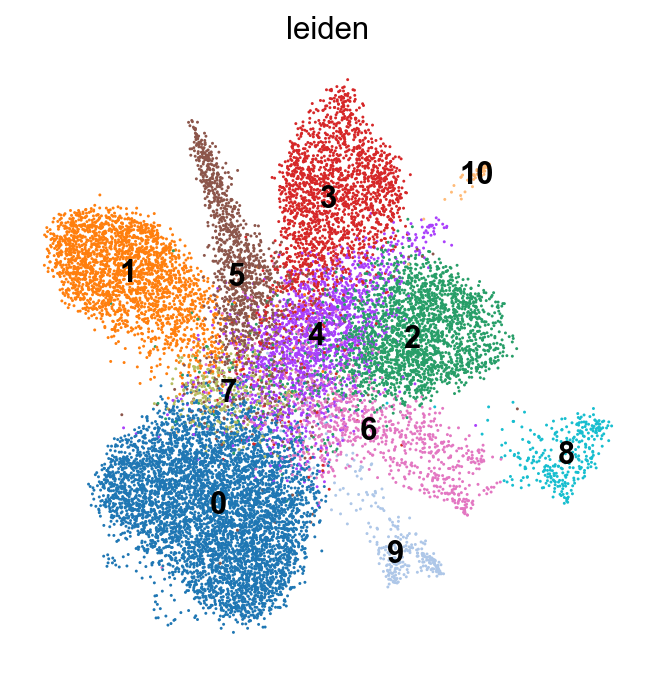

In [45]:
if "X_umap" in mdata.obsm and isinstance(mdata, ad.AnnData):
    sc.pl.umap(mdata, color="leiden",  legend_loc = 'on data')
else:
    snap.pl.umap(mdata, color="leiden", show=True)


## Pitfalls and Extensions

Common pitfalls:
- The RNA and ATAC objects must share cell barcodes. If they do not, integration is not meaningful.
- Keep ATAC in memory (`backed=None`) for this workflow because graph construction needs writable arrays.
- If memory is limited, reduce feature counts before `snap.tl.spectral`.

Extension ideas:
- Compare modality-specific and multimodal clusters with contingency tables.
- Add marker-gene and marker-peak annotation for biological interpretation.
- Re-run integration after changing ATAC feature selection parameters.


## Exercises

1. Compare multimodal Leiden clusters against RNA-only Leiden clusters with a contingency table.
2. Recompute ATAC embeddings with a different feature-selection threshold and compare cluster stability.


In [46]:
# Exercise answer scaffold
import pandas as pd

comparison = pd.concat(
    [
        rna_shared.obs["leiden"].rename("rna_leiden"),
        atac_shared.obs["leiden"].rename("atac_leiden"),
        mdata.obs["leiden"].rename("multi_leiden"),
    ],
    axis=1,
).dropna()

comparison.head()


,rna_leiden,atac_leiden,multi_leiden
06_LPC5S1:GAACCAGAAACGTGAT,1,2,3
06_LPC5S1:GTGACAAGAACGTGAT,1,2,3
06_LPC5S1:CGGAAGAAAACGTGAT,1,2,4
06_LPC5S1:GCCAAGACAACGTGAT,1,4,4
06_LPC5S1:GATGAATCAACGTGAT,1,2,3


In [47]:
pd.crosstab(comparison["multi_leiden"], comparison["rna_leiden"])


rna_leiden,0,1,2,3,4,5,6,7,8
multi_leiden,,,,,,,,,
0,4342,64,836,29,10,26,26,5,0
1,25,42,109,43,2100,8,6,2,0
2,58,179,107,1843,49,30,26,5,1
3,36,1800,96,22,10,22,3,2,2
4,201,872,370,243,72,34,28,13,1
5,78,113,476,91,15,11,481,3,0
6,56,117,232,67,16,380,12,6,1
7,46,8,195,25,17,0,10,3,0
8,0,0,0,1,0,303,0,0,0
